
#### Importing Libraries

In [47]:
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

![kneeding](https://media.giphy.com/media/RpckSiHL6ZaXS/giphy.gif)

# Enhancing Regression Models

Objectives, be able to use:

Pre-processing:
- handling non-numeric data
 - categorical: get_dummies/one-hot-encoder
 - binary encoder
 - ordinal: label encoder
- Scaling

Creating New:
- Interaction terms
- Polynomials


Evaluating:
- R^2 vs adjusted R^2
- comparing model performance metrics - metrics going up or down?


## Scenario: car seat sales

Description: simulated data set on sales of car seats<br>
Format: 400 observations on the following 11 variables
- Sales: unit sales at each location
- CompPrice: price charged by nearest competitor at each location
- Income: community income level
- Advertising: local advertising budget for company at each location
- Population: population size in region (in thousands)
- Price: price charged for car seat at each site
- **ShelveLoc: quality of shelving location at site (Good | Bad | Medium)**
- Age: average age of the local population
- Education: education level at each location
- **Urban: whether the store is in an urban or rural location**
- **USA: whether the store is in the US or not**

 We will attempt to predict ${\tt Sales}$ (child car seat sales) in 400 locations based on a number of predictors.

In [48]:
original_df = pd.read_csv('Carseats.csv')
df = original_df.copy()

In [49]:
df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [50]:
from sklearn.model_selection import train_test_split
X = df.drop('Sales', axis=1)
y = df['Sales']

# Train-test split, then "set aside" test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [51]:
# Drop duplicates, drop na's
X_train.drop_duplicates(inplace=True)
X_train.dropna(inplace=True)


## Numeric Data

In [52]:
# Select only numeric. 
# Excluding 'object' type removes categorical features 
X_train_numeric = X_train.select_dtypes(exclude='object')
# Save columns names because they will have to be reattached after scaling
X_numeric_columns = X_train_numeric.columns

In [53]:
from sklearn.preprocessing import StandardScaler
from scipy import stats

ss = StandardScaler()

X_train_numeric = pd.DataFrame(ss.fit_transform(X_train_numeric))
X_train_numeric.set_index(X_train.index, inplace=True)
X_train_numeric.columns = X_numeric_columns
# Remove outliers, i.e. data points outside of 2.5 standard deviations of the mean
X_train_numeric = X_train_numeric[(np.abs(stats.zscore(X_train_numeric)) < 2.5).all(axis=1)]
X_train_numeric.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education
157,-0.237664,-0.321877,0.259459,-0.117029,-1.111241,-0.311341,-0.321613
109,-0.619016,-0.075054,-0.979749,-0.338483,-1.111241,0.418670,1.204686
17,1.414862,0.242290,1.033964,-0.103189,0.612451,-0.068004,-1.466337
347,-1.826631,-0.991826,-0.979749,-0.726027,-0.186333,-1.588861,0.059962
24,1.287744,1.829009,1.498667,0.194390,-0.144292,-0.676347,-0.703188


In [54]:
# Ten outliers were removed
X_train.shape[0] - X_train_numeric.shape[0]

10

## Categorical data

In [55]:
X_train_cat = X_train.select_dtypes(include='object')
# Remember that we will have to align the shape of categorical and numeric sets 
X_train_cat.shape

(280, 3)

In [56]:
# Categorical data
from sklearn.preprocessing import LabelBinarizer

# LabelBinarizer converts features with binary values to 0 and 1

urban_bin = LabelBinarizer()
us_bin = LabelBinarizer()
X_train_cat['Urban'] = urban_bin.fit_transform(X_train_cat['Urban'])
X_train_cat['US'] = us_bin.fit_transform(X_train_cat['US'])
X_train_cat.head()


,ShelveLoc,Urban,US
157,Medium,0,1
109,Medium,0,0
17,Good,1,1
347,Good,0,0
24,Bad,1,1


In [57]:
X_train_cat_prepped = X_train_cat.merge(pd.get_dummies(X_train_cat['ShelveLoc'], drop_first=True),
                  left_index=True, right_index=True)
X_train_cat_prepped.drop('ShelveLoc', axis=1, inplace=True)
X_train_cat_prepped.head()

,Urban,US,Good,Medium
157,0,1,0,1
109,0,0,0,1
17,1,1,1,0
347,0,0,1,0
24,1,1,0,0


In [58]:
# OneHotEncoder is the sklearn alternative
from sklearn.preprocessing import OneHotEncoder
oh = OneHotEncoder(sparse=False, drop='first')
oh.fit_transform(X_train_cat[['ShelveLoc']])
oh.categories_

[array(['Bad', 'Good', 'Medium'], dtype=object)]

In [59]:
X_train_prep = pd.merge(X_train_cat_prepped, X_train_numeric, left_index=True, right_index=True)
X_train_prep.shape

(270, 11)

In [60]:
y_train = y_train.loc[X_train_prep.index]
y_train

157    10.21
109     8.98
17     12.29
347     6.88
24     10.14
       ...  
71      6.50
106     0.16
270    11.99
348    12.57
102     5.30
Name: Sales, Length: 270, dtype: float64

In [61]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_prep, y_train)
y_hat_train = lr.predict(X_train_prep)
lr.coef_

array([ 0.13975914, -0.31212813,  4.87980698,  2.09252589,  1.45925336,
        0.38851707,  0.82948647,  0.05027613, -2.31246649, -0.78961971,
       -0.08078303])

In [62]:
from sklearn.metrics import r2_score, mean_squared_error

print(f"r^2: {r2_score(y_train, y_hat_train)}")
print(f"rmse: {np.sqrt(mean_squared_error(y_train, y_hat_train))}")

r^2: 0.8644163238219125
rmse: 0.9802317672269527


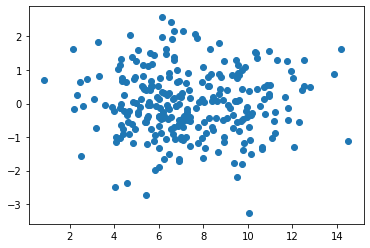

In [63]:
# Check assumptions
residuals = y_hat_train - y_train
import matplotlib.pyplot as plt

plt.scatter(y_hat_train, residuals)

# Check that residuals are normally distributed

(-3.897092294690922, 4)

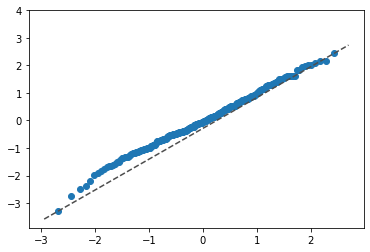

In [64]:
sorted_residuals = sorted(residuals)
probs = [x/(len(residuals)+1) for x in range(1, len(residuals))]
z_scores = [stats.norm.ppf(prob) for prob in probs]
fig, ax = plt.subplots()
ax.scatter(z_scores, sorted(residuals)[0:-1])
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
ax.set_ylim(top = 4)

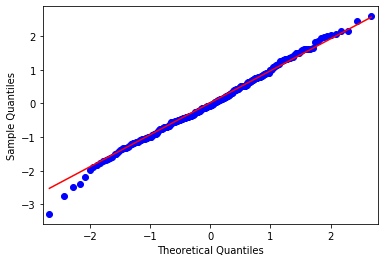

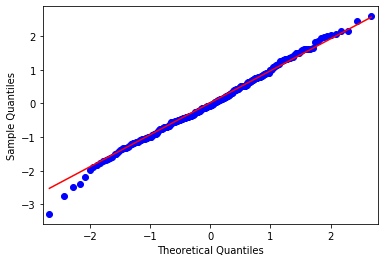

In [65]:
from statsmodels.graphics.gofplots import qqplot
qqplot(residuals, line='q')

# Check for covariance


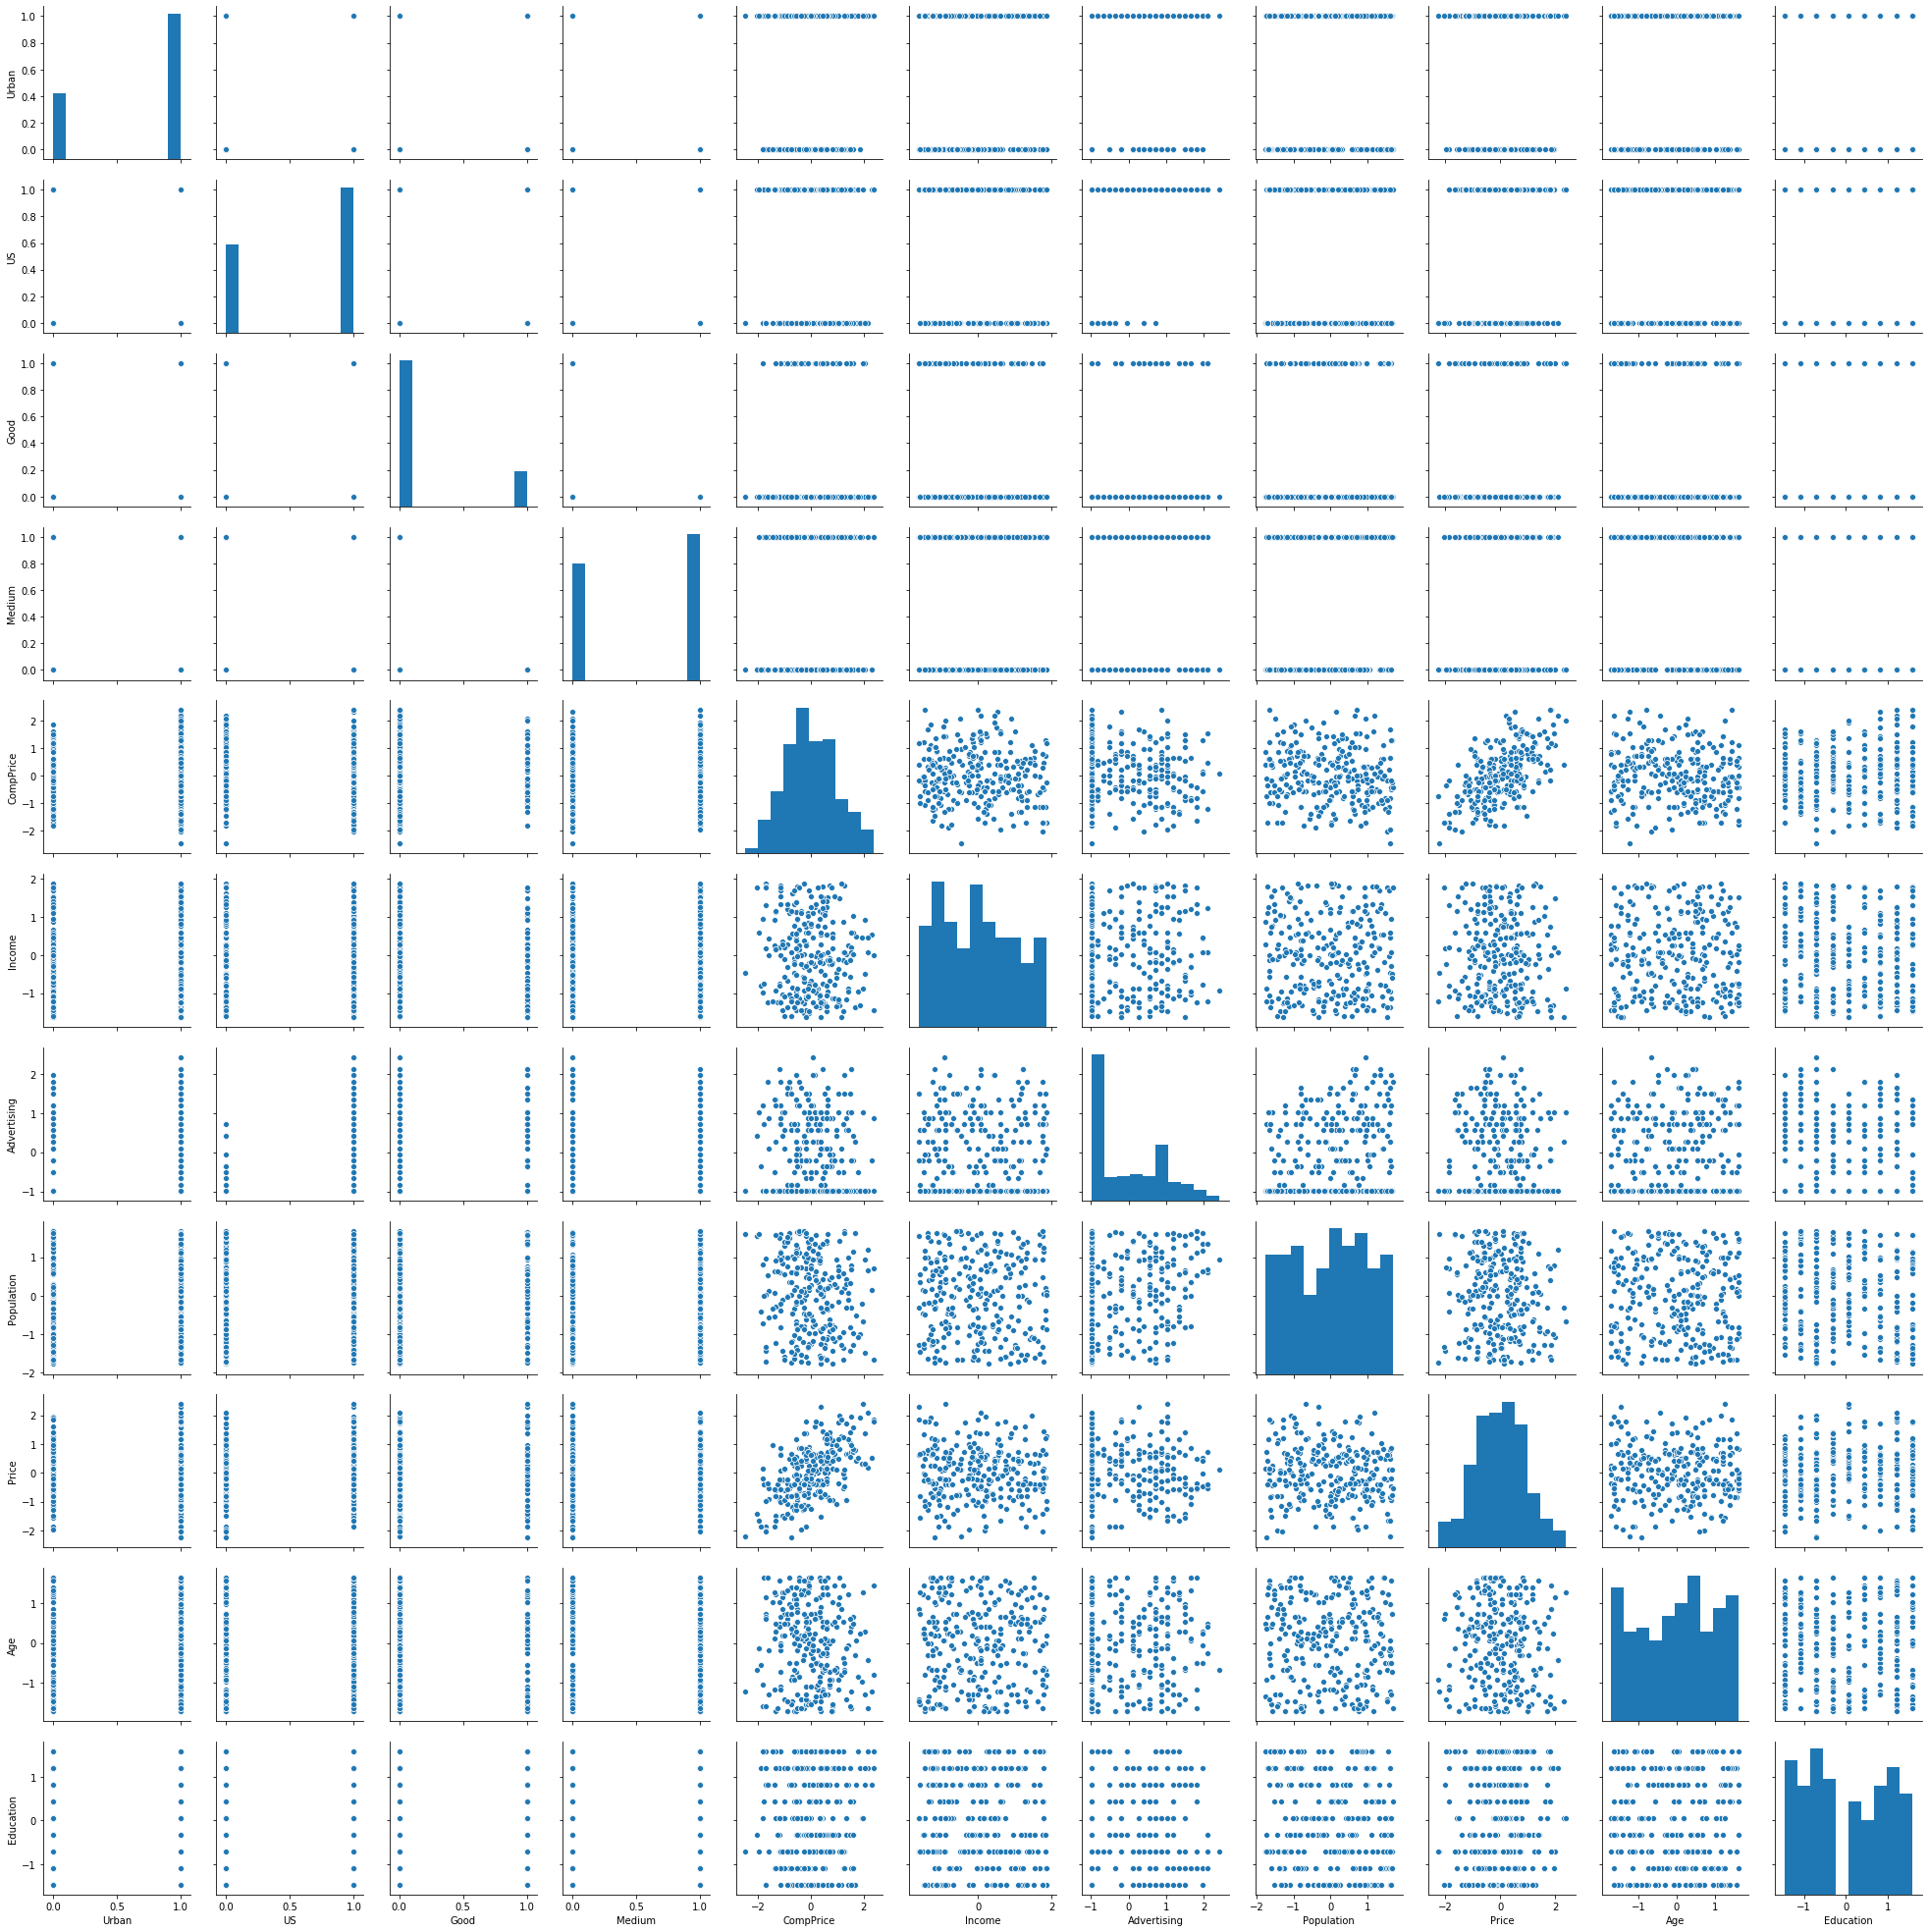

In [66]:
import seaborn as sns
sns.pairplot(X_train_prep.select_dtypes(exclude='object'))

In [67]:
X_train_prep.cov()

,Urban,US,Good,Medium,CompPrice,Income,Advertising,Population,Price,Age,Education
Urban,0.215118,0.015861,-0.009335,-0.012392,0.048563,0.016201,0.010723,-0.026858,0.028298,0.014041,-0.035715
US,0.015861,0.235936,0.011235,-0.012392,-0.005686,0.027763,0.334998,0.050886,0.014670,-0.009991,-0.056235
Good,-0.009335,0.011235,0.158351,-0.109459,0.009186,-0.046516,0.018873,0.007790,0.038487,-0.001607,-0.003961
Medium,-0.012392,-0.012392,-0.109459,0.247831,0.003623,-0.002884,0.005119,-0.012918,-0.000208,0.022062,-0.012924
CompPrice,0.048563,-0.005686,0.009186,0.003623,0.909270,-0.078542,-0.073919,-0.116141,0.505692,-0.079530,0.055541
Income,0.016201,0.027763,-0.046516,-0.002884,-0.078542,1.008906,0.049168,-0.025161,-0.048146,-0.032352,-0.133788
Advertising,0.010723,0.334998,0.018873,0.005119,-0.073919,0.049168,0.927200,0.260936,-0.012439,0.002224,-0.099525
Population,-0.026858,0.050886,0.007790,-0.012918,-0.116141,-0.025161,0.260936,1.011351,-0.073411,-0.066464,-0.152799
Price,0.028298,0.014670,0.038487,-0.000208,0.505692,-0.048146,-0.012439,-0.073411,0.845723,-0.039695,0.044553
Age,0.014041,-0.009991,-0.001607,0.022062,-0.079530,-0.032352,0.002224,-0.066464,-0.039695,1.000918,0.011391


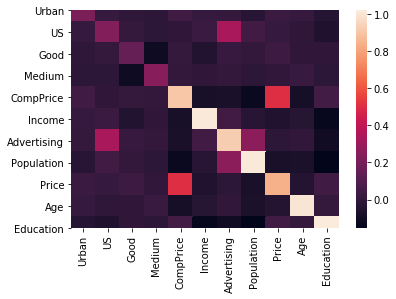

In [137]:
sns.heatmap(X_train_prep.cov())

In [138]:
X_train_prep.drop('CompPrice', axis=1, inplace=True)

In [139]:
lr = LinearRegression()
lr.fit(X_train_prep, y_train)
y_hat_train = lr.predict(X_train_prep)
r2_score(y_train, y_hat_train)

0.6889021741977951

# Feature Engineering

In [140]:
X_train_prep.head()

,Urban,US,Good,Medium,Income,Advertising,Population,Price,Age,Education
157,0,1,0,1,-0.321877,0.259459,-0.117029,-1.111241,-0.311341,-0.321613
109,0,0,0,1,-0.075054,-0.979749,-0.338483,-1.111241,0.418670,1.204686
17,1,1,1,0,0.242290,1.033964,-0.103189,0.612451,-0.068004,-1.466337
347,0,0,1,0,-0.991826,-0.979749,-0.726027,-0.186333,-1.588861,0.059962
24,1,1,0,0,1.829009,1.498667,0.194390,-0.144292,-0.676347,-0.703188


In [141]:
from itertools import combinations
column_list = X_train_prep.columns
interactions = list(combinations(column_list, 2))
interaction_dict = {}

for interaction in interactions:
    X_train_int = X_train_prep
    X_train_int['int'] = X_train_int[interaction[0]]*X_train_int[interaction[1]]
    lr = LinearRegression()
    lr.fit(X_train_int, y_train)
    interaction_dict[lr.score(X_train_int, y_train)] = interaction

top_five = sorted(interaction_dict.keys(), reverse=True)[:5]
for inter in top_five:
    print(interaction_dict[inter])

('US', 'Advertising')
('US', 'Age')
('US', 'Good')
('Advertising', 'Age')
('Income', 'Price')


In [142]:
X_train_int = X_train_prep
X_train_int['ad_age'] = X_train_int["Advertising"]*X_train_int['Age']
X_train_int['inc_price'] = X_train_int['Income']*X_train_int['Price']
lr = LinearRegression()
lr.fit(X_train_int, y_train)
lr.score(X_train_int, y_train)

0.6932196805192555

In [143]:
# Polynomials
from sklearn.preprocessing import PolynomialFeatures
poly_dict = {}
for feature in X_train_int.columns:
    for p in range(2,5):
        X_train_poly = X_train_int
        X_train_poly['sq'] = X_train_poly[feature]**p
        lr = LinearRegression()
        lr.fit(X_train_poly, y_train)
        poly_dict[lr.score(X_train_poly, y_train)] = [feature, p]
    
poly_dict[max(poly_dict.keys())]

['ad_age', 3]

In [144]:
X_train_final = X_train_int
X_train_final['ad_age_cubed'] = X_train_final['ad_age']**3
X_train_final.drop('sq',axis=1,inplace=True)

In [145]:
lr = LinearRegression()
lr.fit(X_train_final, y_train)
lr.score(X_train_final, y_train)

0.6981098695067475

To learn how to set other coding schemes (or _contrasts_), see: http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/contrasts.html

Polynomials have diminishing returns!

![polynomials](https://sc.cnbcfm.com/applications/cnbc.com/resources/files/2015/12/11/emotionandincome-01_0.png)

In [146]:
# For fun, let's test out changing our categorical shelf location 
# to ordinal labels

X_train_ord = X_train_prep.copy()
X_train_ord = X_train_ord.merge(X_train['ShelveLoc'], left_index=True, right_index=True)
X_train_ord.drop(['Good', 'Medium'], axis=1, inplace=True)


In [147]:
def shelf_ord(value):
    if value == 'Bad':
        return 0
    elif value == 'Medium':
        return 1
    else:
        return 2

X_train_ord['ShelveLoc'] = X_train_ord["ShelveLoc"].map(shelf_ord)



In [148]:
X_train_ord.head()

,Urban,US,Income,Advertising,Population,Price,Age,Education,int,ad_age,inc_price,ad_age_cubed,ShelveLoc
157,0,1,-0.321877,0.259459,-0.117029,-1.111241,-0.311341,-0.321613,0.100131,-0.080780,0.357683,-0.000527,1
109,0,0,-0.075054,-0.979749,-0.338483,-1.111241,0.418670,1.204686,0.504366,-0.410192,0.083403,-0.069018,1
17,1,1,0.242290,1.033964,-0.103189,0.612451,-0.068004,-1.466337,0.099717,-0.070314,0.148391,-0.000348,2
347,0,0,-0.991826,-0.979749,-0.726027,-0.186333,-1.588861,0.059962,-0.095271,1.556685,0.184810,3.772266,2
24,1,1,1.829009,1.498667,0.194390,-0.144292,-0.676347,-0.703188,0.475599,-1.013619,-0.263911,-1.041416,0


In [149]:
lr_ord = LinearRegression()
lr_ord.fit(X_train_ord, y_train)
lr_ord.score(X_train_ord, y_train)

0.6945268465894836

# Validate

We are fairly happy we our test r^2, so we validate on our test set

In [150]:
X_test.drop_duplicates(inplace=True)
X_test.dropna(inplace=True)
X_test_numeric = X_test.select_dtypes(exclude='object')
X_numeric_columns = X_test_numeric.columns
X_test_numeric = pd.DataFrame(ss.fit_transform(X_test_numeric))
X_test_numeric.set_index(X_test.index, inplace=True)
X_test_numeric.columns = X_numeric_columns
X_test_numeric = X_test_numeric[(np.abs(stats.zscore(X_test_numeric)) < 2.5).all(axis=1)]


In [151]:
X_test_cat = X_test.select_dtypes(include='object')
X_test_cat['Urban'] = urban_bin.fit_transform(X_test_cat['Urban'])
X_test_cat['US'] = us_bin.fit_transform(X_test_cat['US'])
X_test_cat_prepped = X_test_cat.merge(pd.get_dummies(X_test_cat['ShelveLoc'], drop_first=True),
                  left_index=True, right_index=True)
X_test_cat_prepped.drop('ShelveLoc', axis=1, inplace=True)
X_test_prep = pd.merge(X_test_cat_prepped, X_test_numeric, left_index=True, right_index=True)
X_test_prep.shape

(115, 11)

In [152]:
y_test = y_test.loc[X_test_prep.index]
y_test.shape

(115,)

In [153]:
X_test_prep['ad_age'] = X_test_prep["Advertising"]*X_test_prep['Age']
X_test_prep['inc_price'] = X_test_prep['Income']*X_test_prep['Price']
X_test_prep['ad_age_cubed'] = X_test_prep['ad_age']**3


In [154]:
X_test_prep.head()

,Urban,US,Good,Medium,CompPrice,Income,Advertising,Population,Price,Age,Education,ad_age,inc_price,ad_age_cubed
209,0,1,0,0,-1.927926,-1.923401,0.519903,0.415358,-1.045455,1.427581,-1.164754,0.742203,2.010828,0.408854
280,1,1,0,0,-0.316943,0.517225,0.377138,1.524573,1.319989,-0.180055,-1.548739,-0.067906,0.682731,-0.000313
33,1,1,1,0,-0.807242,-1.285083,0.805433,0.356634,0.588852,-0.244361,0.755170,-0.196816,-0.756724,-0.007624
210,0,1,0,0,-0.036772,-1.172439,-0.764983,0.617626,0.373812,-0.437277,-0.012799,0.334509,-0.438271,0.037430
93,1,0,0,1,1.364082,-1.585468,-1.050513,-1.274564,-0.443342,0.077167,1.139155,-0.081064,0.702904,-0.000533


In [155]:
lr.score(X_test_prep, y_test)

0.40416685329194846

# Statsmodels

Sklearn may be a bit easier to use, but statsmodels offers a wider range of summary statistics, including adjusted r^2.

In [156]:
import statsmodels.formula.api as smf
feature_formula = " + ".join(X_train_prep.columns)
sm_formula = 'Sales ~ ' + feature_formula

train_data = pd.merge(y_train, X_train_prep, left_index=True, right_index=True)
results = smf.ols(sm_formula, data=train_data).fit()

In [157]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     42.12
Date:                Thu, 19 Dec 2019   Prob (F-statistic):           3.97e-58
Time:                        07:49:53   Log-Likelihood:                -485.79
No. Observations:                 270   AIC:                             1002.
Df Residuals:                     255   BIC:                             1056.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.2084      0.303     17.199      0.000       4.612       5.805
Urban            0.3660      0.202      1.811      0.071      -0.032       0.764
US              -0.2520      0.276     -0.911      0.363      -0.796       0.292
Good             4.7154      0.286     16.481      0.000       4.152       5.279
Medium           2.0301      0.227      8.953      0.000       1.584       2.477
Income           0.2810      0.094      2.983      0.003       0.096       0.467
Advertising      0.7250      0.144      5.031      0.000       0.441       1.009
Population      -0.0443      0.098     -0.452      0.651      -0.237       0.148
Price           -1.4771      0.102    -14.419      0.000      -1.679      -1.275
Age             -0.8495      0.097     -8.770      0.000      -1.040      -0.659
Education       -0.0610      0.095     -0.644      0.520      -0.247       0.126
int              0.0603      0.095      0.633      0.527      -0.127       0.248
ad_age           0.1271      0.162      0.784      0.434      -0.192       0.446
inc_price       -0.1053      0.098     -1.071      0.285      -0.299       0.088
ad_age_cubed    -0.0936      0.046     -2.032      0.043      -0.184      -0.003
==============================================================================
Omnibus:                        0.041   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.980   Jarque-Bera (JB):                0.111
Skew:                           0.026   Prob(JB):                        0.946
Kurtosis:                       2.916   Cond. No.                         15.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
feature_columns = list(X_train_prep.columns)
high_p = ['Urban','US', 'Population',"Education", 'int', 'ad_age', 'inc_price']
for feature in high_p:
    feature_columns.remove(feature)
feature_columns

['Good', 'Medium', 'Income', 'Advertising', 'Price', 'Age', 'ad_age_cubed']

In [55]:
new_feature_formula = " + ".join(feature_columns)
sm_formula = 'Sales ~ ' + new_feature_formula

train_data = pd.merge(y_train, X_train_prep.drop(high_p, axis=1), 
                      left_index=True, right_index=True)
results = smf.ols(sm_formula, data=train_data).fit()

In [56]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     83.51
Date:                Thu, 19 Dec 2019   Prob (F-statistic):           4.60e-63
Time:                        07:24:11   Log-Likelihood:                -489.14
No. Observations:                 270   AIC:                             994.3
Df Residuals:                     262   BIC:                             1023.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.3231      0.186     28.603      0.000       4.957       5.690
Good             4.6745      0.283     16.546      0.000       4.118       5.231
Medium           2.0172      0.223      9.027      0.000       1.577       2.457
Income           0.2925      0.093      3.142      0.002       0.109       0.476
Advertising      0.6491      0.096      6.788      0.000       0.461       0.837
Price           -1.4592      0.101    -14.488      0.000      -1.658      -1.261
Age             -0.8528      0.092     -9.246      0.000      -1.034      -0.671
ad_age_cubed    -0.0664      0.028     -2.376      0.018      -0.121      -0.011
==============================================================================
Omnibus:                        0.313   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.855   Jarque-Bera (JB):                0.181
Skew:                           0.057   Prob(JB):                        0.914
Kurtosis:                       3.056   Cond. No.                         13.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Note
Statsmodel outputs a Durbin-Watson score between 0 and 4, with a value of 2 indicating no autocorrelation. Autocorrelated datasets will be the subject of time series at the end of the mod.
This is the 5th assumption of linear regression.  Our model passes.